# Generating Synthetic PV Power Time Series

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import pvlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

import utils, clean_data, generate_pv

In [2]:
config_path = "config.yaml"
config = utils.load_config(config_path)

dir = os.path.join(config['data']['raw_dir'], 'solar')
features = config['features']
params = config['pv_params']
db_config = config['write']['db_conf']

pv_features, _ = clean_data.relevant_features(features=features)

plot_names = ['Global', 'Direct', 'Diffuse']

In [3]:
files = os.listdir(dir)
station_id = '00183'
file = [station for station in files if station_id in station][0]

data = pd.read_csv(os.path.join(dir, file))
data['timestamp'] = pd.to_datetime(data['timestamp'])
#df['timestamp'] = df['timestamp'].dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")
data.set_index('timestamp', inplace=True)
data = data.resample('1H', closed='left', label='left', origin='start').mean()
data = data[pv_features]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15696 entries, 2023-07-24 00:00:00+00:00 to 2025-05-07 23:00:00+00:00
Freq: H
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ghi             15691 non-null  float64
 1   dhi             15691 non-null  float64
 2   temperature_2m  15696 non-null  float64
 3   wind_speed      15694 non-null  float64
dtypes: float64(4)
memory usage: 613.1 KB


### Analysis of missing values

In [5]:
data.isna().sum()

ghi               5
dhi               5
temperature_2m    0
wind_speed        2
dtype: int64

In [6]:
missing_per_column_per_day = data.groupby(data.index.date).apply(lambda x: x.isna().sum())
missing_per_column_per_day[(missing_per_column_per_day != 0).any(axis=1)]

,ghi,dhi,temperature_2m,wind_speed
2023-08-16,3,3,0,0
2024-02-14,1,1,0,2
2024-11-13,1,1,0,0


In [7]:
df = utils.knn_imputer(data=data, n_neighbors=5)

In [8]:
def plot_power_and_features(day: str,
                            plot_names: list,
                            features: list,
                            power: pd.Series,
                            synchronize_axes=True,
                            save_fig=False):

    # konvertiere und ggf. lokalisiere Timestamp
    tz = power.index.tz
    day = pd.Timestamp(day).tz_localize(tz) if tz is not None else pd.Timestamp(day)

    # boolesche Maske für einen Tag
    mask = (power.index >= day) & (power.index < day + pd.Timedelta(days=1))
    power_day = power.loc[mask]
    features_day = [f.loc[mask] for f in features]

    if power_day.empty or any(f.empty for f in features_day):
        print(f"WARNUNG: Kein Datenpunkt für den Tag {day.date()}")
        return

    date = str(day.date())
    fig, ax1 = plt.subplots(figsize=(10, 6))
    fontsize = 14
    lines = []
    title_suffix = ''

    # power plotten
    line1, = ax1.plot(power_day, label="Power Output (W)", color="black", linewidth=2.0)
    lines.append(line1)

    ax1.set_xlabel("Time", fontsize=fontsize)
    ax1.set_ylabel("Power Output (W)", fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize - 2)

    ax2 = ax1.twinx()

    for name, series in zip(plot_names, features_day):
        if series.empty:
            continue
        line, = ax2.plot(series, label=f"{name} (W/m$^2$)", linestyle='--', linewidth=2.0)
        lines.append(line)

    ax2.set_ylabel("Energy flux density (W/m$^2$)", fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)

    # x-Achse formatieren
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ticks = ax1.get_xticks()
    ax1.set_xticks(ticks[1:-1])

    # Achsen synchronisieren
    if synchronize_axes:
        title_suffix = '(synched axes)'
        all_ghi_min = min([s.min() for s in features_day if not s.empty])
        all_ghi_max = max([s.max() for s in features_day if not s.empty])
        y_min = min(all_ghi_min, power_day.min())
        y_max = max(all_ghi_max, power_day.max())
        ax1.set_ylim(y_min, y_max)
        ax2.set_ylim(y_min, y_max)

    # Legende
    lines.append(lines.pop(0))  # Power zuerst
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left", fontsize=fontsize)

    plt.title(f"Irradiance and Power Output on {date} {title_suffix}", fontsize=fontsize)
    fig.tight_layout()

    if save_fig:
        save_path = 'figs/days'
        os.makedirs(save_path, exist_ok=True)
        save_file = os.path.join(save_path, f'{date}.png')
        plt.savefig(save_file, dpi=600)
        plt.close()
    else:
        plt.show()

In [9]:
location_n_elevation = generate_pv.get_location_and_elevation(station_id=station_id,
                                                              db_config=db_config)
params['latitude'], params['longitude'], params['elevation'] = location_n_elevation

total_irradiance, cell_temperature = generate_pv.get_features(data=df,
                                                              features=features,
                                                              params=params)
total = total_irradiance['poa_global']
direct = total_irradiance['poa_direct']
diffuse = total_irradiance['poa_diffuse']
#sky_dhi = total_irradiance['poa_sky_diffuse']
#ground_dhi = total_irradiance['poa_ground_diffuse']

power = generate_pv.generate_pv_power(total_irradiance=total,
                                      cell_temperature=cell_temperature,
                                      params=params)

In [15]:
mean_age_years = 10
std_dev_age_years = 3.33
time_vector = df.index
start_age = np.random.normal(loc=mean_age_years, scale=std_dev_age_years)
start_age = max(0.0, start_age)
end_age = start_age + 1
commissioning_date = str((time_vector[0] - pd.Timedelta(days=start_age*365.25)).date())

Power and irradiance on the plane of array


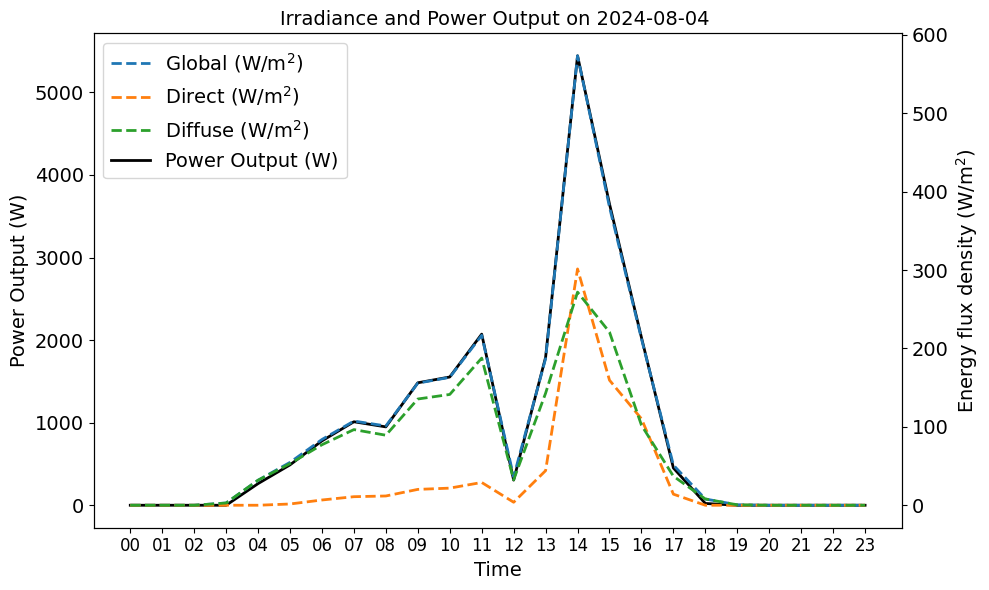

Power and irradiance on the horizontal


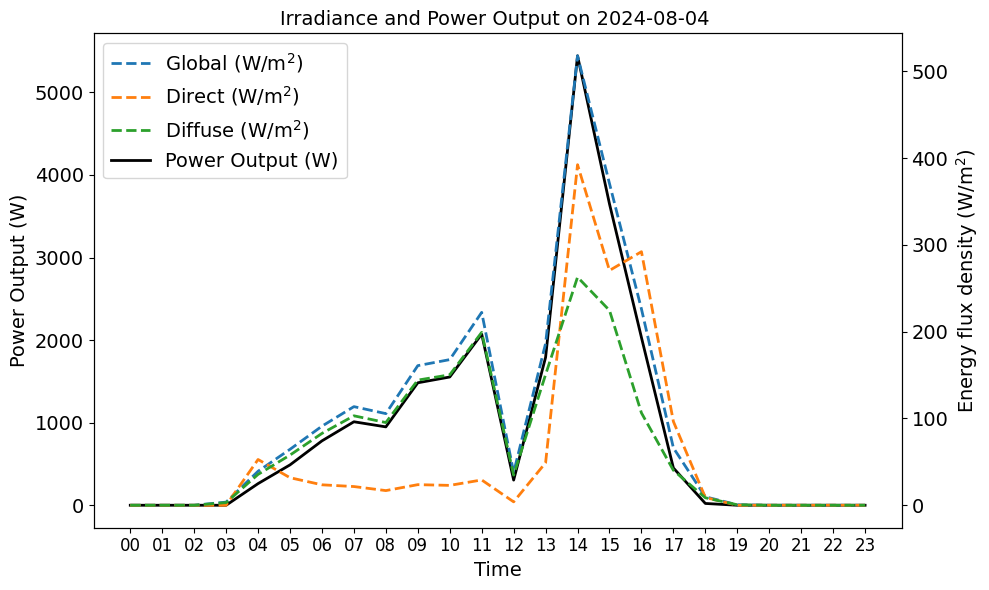

In [11]:
day = '2024-08-04'
plot_features = [total, direct, diffuse]

print('Power and irradiance on the plane of array')
plot_power_and_features(day=day,
                        plot_names=plot_names,
                        features=plot_features,
                        power=power,
                        synchronize_axes=False,
                        save_fig=False)

plot_features = [df.ghi, df.dni, df.dhi]
print('Power and irradiance on the horizontal')
plot_power_and_features(day=day,
                        plot_names=plot_names,
                        features=plot_features,
                        power=power,
                        synchronize_axes=False,
                        save_fig=False)

In [12]:
# for day in np.unique(df.index.date):
#     plot_power_and_features(day=str(day),
#                             plot_names=plot_names,
#                             features=plot_features,
#                             power=power,
#                             synchronize_axes=False,
#                             save_fig=True)